In [1]:
#! /usr/bin/env python

from __future__ import print_function
import os
import numpy as np
#from read_psf_cats import read_data, band_combinations
import fitsio
import treecorr
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
from astropy.io import fits

In [2]:

hdul =fits.open('/global/homes/m/mjarvis/desdata/users/mjarvis/y3a1-v29/psf_y3a1-v29.fits')
cols = hdul[1].columns
print(cols)

ColDefs(
    name = 'ra'; format = 'D'
    name = 'dec'; format = 'D'
    name = 'x'; format = 'D'
    name = 'y'; format = 'D'
    name = 'obs_e1'; format = 'D'
    name = 'obs_e2'; format = 'D'
    name = 'obs_T'; format = 'D'
    name = 'piff_e1'; format = 'D'
    name = 'piff_e2'; format = 'D'
    name = 'piff_T'; format = 'D'
    name = 'mag'; format = 'D'
    name = 'fov_x'; format = 'D'
    name = 'fov_y'; format = 'D'
    name = 'exp'; format = 'J'
    name = 'ccd'; format = 'I'
    name = 'band'; format = '1A'
    name = 'tiling'; format = 'I'
)


In [50]:
prefix='piff' #'psfex'
data = fitsio.read('/global/homes/m/mjarvis/desdata/users/mjarvis/y3a1-v29/psf_y3a1-v29.fits')
#print(data)
h = fitsio.read_header('/global/homes/m/mjarvis/desdata/users/mjarvis/y3a1-v29/psf_y3a1-v29.fits')
#print(h)

[ra, dec] = [data['ra'], data['dec'] ]
print(np.sort(data['ra']))
print(data['band'])



[  3.88902716e-06   5.80241940e-06   1.48305890e-05 ...,   3.59999980e+02
   3.59999990e+02   3.59999997e+02]
['z' 'z' 'z' ..., 'z' 'z' 'z']


[228724 228724 228724 ..., 516796 516796 516796]
[ 1  1  1 ..., 62 62 62]
62
2804
[ 18.7433567   17.51895905  20.93354988 ...,  18.09413147  18.54286194
  20.3592968 ]


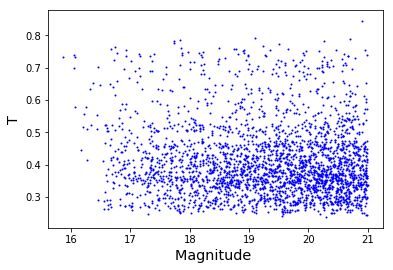

In [54]:
band=data['band']
thisband="i"
data=data[np.where(band ==thisband)]

print(data['exp'])
print(data['ccd'])
print(max(data['ccd']))
ccd=data['ccd']
exp=data['exp']
thisdata=data[np.where(ccd ==62) ]
thisdata=thisdata[np.where(exp ==228724) ]
print(len(thisdata))
print(thisdata['mag'])
plt.scatter(thisdata['mag'],thisdata['piff_T'],c='blue', marker='.',s=4)
plt.xlabel(r'Magnitude ', fontsize='x-large')
plt.ylabel(r'T', fontsize='x-large')
#plt.title('g-only')

In [38]:
def compute_res(d):

    de1 =  d['obs_e1']-d[prefix+'_e1']
    de2 =  d['obs_e2']-d[prefix+'_e2']
    dt =  (d['obs_T']-d[prefix+'_T'])
    dtfrac = dt/d['obs_T']
    #for k in range(len(tile_data)):
    #print('k = ',k)
    print('mean de = ',np.mean(de1),np.mean(de2))
    print('mean dt = ',np.mean(dt))
    
    plt.hist(dtfrac)
    plt.xlabel(r'$(T_{\rm PSF} - T_{\rm model})/ T_{\rm PSF}$', fontsize='x-large')
    plt.title('g-only')

    return dtfrac, dt,  de1, de2

mean de =  4.61845810697e-05 -8.02126901127e-06
mean dt =  -0.000390553971401


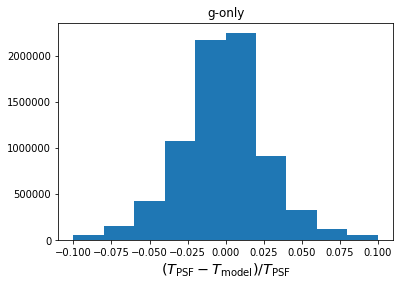

In [39]:
fracsizeres, sizeres, e1res, e2res=compute_res(data)

In [14]:
#want psf vs mag- brighter vs fatter
def bin_by_mag(m, dT, dTfrac, de1, de2, min_mused):
    min_mag = 15
    max_mag = 21
     
    mag_bins = np.linspace(min_mag,max_mag,71)
    print('mag_bins = ',mag_bins)

    index = np.digitize(m, mag_bins)
    print('len(index) = ',len(index))
    bin_de1 = [de1[index == i].mean() for i in range(1, len(mag_bins))]
    print('bin_de1 = ',bin_de1)
    bin_de2 = [de2[index == i].mean() for i in range(1, len(mag_bins))]
    print('bin_de2 = ',bin_de2)
    bin_dT = [dT[index == i].mean() for i in range(1, len(mag_bins))]
    print('bin_dT = ',bin_dT)
    bin_dTfrac = [dTfrac[index == i].mean() for i in range(1, len(mag_bins))]
    print('bin_dTfrac = ',bin_dTfrac)
    bin_de1_err = [ np.sqrt(de1[index == i].var() / len(de1[index == i]))
                    for i in range(1, len(mag_bins)) ]
    print('bin_de1_err = ',bin_de1_err)
    bin_de2_err = [ np.sqrt(de2[index == i].var() / len(de2[index == i]))
                    for i in range(1, len(mag_bins)) ]
    print('bin_de2_err = ',bin_de2_err)
    bin_dT_err = [ np.sqrt(dT[index == i].var() / len(dT[index == i]))
                    for i in range(1, len(mag_bins)) ]
    print('bin_dT_err = ',bin_dT_err)
    bin_dTfrac_err = [ np.sqrt(dTfrac[index == i].var() / len(dTfrac[index == i]))
                    for i in range(1, len(mag_bins)) ]
    print('bin_dTfrac_err = ',bin_dTfrac_err)

    # Fix up nans
    for i in range(1,len(mag_bins)):
        if i not in index:
            bin_de1[i-1] = 0.
            bin_de2[i-1] = 0.
            bin_dT[i-1] = 0.
            bin_dTfrac[i-1] = 0.
            bin_de1_err[i-1] = 0.
            bin_de2_err[i-1] = 0.
            bin_dT_err[i-1] = 0.
            bin_dTfrac_err[i-1] = 0.
    #print('fixed nans')
    #print('index = ',index)
    #print('bin_de1 = ',bin_de1)
    #print('bin_de2 = ',bin_de2)
    #print('bin_dT = ',bin_dT)

    fig, axes = plt.subplots(3,1, sharex=True)
    
    ax = axes[0]
    ax.set_ylim(-0.0015,0.0035)
    ax.plot([min_mag,max_mag], [0,0], color='black')
    ax.plot([min_mused,min_mused],[-1,1], color='Grey')
    ax.fill( [min_mag,min_mag,min_mused,min_mused], [-1,1,1,-1], fill=True, color='Grey',alpha=0.3)
    #ax.fill( [18.3,min_mag,min_mused,min_mused], [-1,1,1,-1], fill=True, color='blue',alpha=0.3)
    t_line = ax.errorbar(mag_bins[:-1], bin_dT, yerr=bin_dT_err, color='purple', fmt='o')
    ax.fill( [18.3,18.3,max_mag,max_mag], [0.003,-0.001,-0.001,0.003], fill=True, color='darkturquoise',alpha=0.3)
    #ax.axhline(y=0.003, linewidth=4, color='grey')
    #ax.axhline(y=-0.001, linewidth=4, color='grey')
    #ax.legend([t_line], [r'$\delta T$'])
    ax.set_ylabel(r'$(T_{\rm PSF} - T_{\rm model}) \quad({\rm arcsec}^2)$', fontsize='x-large')

    ax = axes[1]
    ax.set_ylim(-0.003,0.003)
    ax.plot([min_mag,max_mag], [0,0], color='black')
    ax.plot([min_mused,min_mused],[-1,1], color='Grey')
    ax.fill( [min_mag,min_mag,min_mused,min_mused], [-1,1,1,-1], fill=True, color='Grey',alpha=0.3)
    t_line = ax.errorbar(mag_bins[:-1], bin_dTfrac, yerr=bin_dTfrac_err, color='purple', fmt='o')
    #ax.legend([t_line], [r'$\delta T$'])
    ax.set_ylabel(r'$(T_{\rm PSF} - T_{\rm model})/ T_{\rm PSF}$', fontsize='x-large')

    ax = axes[2]
    ax.set_ylim(-3.e-4,4.e-4)
    ax.plot([min_mag,max_mag], [0,0], color='black')
    ax.plot([min_mused,min_mused],[-1,1], color='Grey')
    ax.fill( [min_mag,min_mag,min_mused,min_mused], [-1,1,1,-1], fill=True, color='Grey',alpha=0.3)
    e1_line = ax.errorbar(mag_bins[:-1], bin_de1, yerr=bin_de1_err, color='purple', fmt='o')
    e2_line = ax.errorbar(mag_bins[:-1], bin_de2, yerr=bin_de2_err, color='orange', fmt='o')
    #ax.axhline(y=0.0002, linewidth=4, color='grey')
    #ax.axhline(y=-0.0002, linewidth=4, color='grey')
    ax.fill( [18.3,18.3,max_mag,max_mag], [0.0002,-0.0002,-0.0002,0.0002], fill=True, color='darkturquoise',alpha=0.3)
    ax.legend([e1_line, e2_line], [r'$e_1$', r'$e_2$'], fontsize='x-large')
    ax.set_ylabel(r'$e_{\rm PSF} - e_{\rm model}$', fontsize='x-large')

    ax.set_xlim(min_mag,max_mag)
    ax.set_xlabel('Magnitude', fontsize='x-large')

    fig.set_size_inches(7.0,12.0)
    plt.tight_layout()
    plt.savefig('dpsf_mag_g.pdf')
    plt.show()

mag_bins =  [ 15.          15.08571429  15.17142857  15.25714286  15.34285714
  15.42857143  15.51428571  15.6         15.68571429  15.77142857
  15.85714286  15.94285714  16.02857143  16.11428571  16.2         16.28571429
  16.37142857  16.45714286  16.54285714  16.62857143  16.71428571  16.8
  16.88571429  16.97142857  17.05714286  17.14285714  17.22857143
  17.31428571  17.4         17.48571429  17.57142857  17.65714286
  17.74285714  17.82857143  17.91428571  18.          18.08571429
  18.17142857  18.25714286  18.34285714  18.42857143  18.51428571  18.6
  18.68571429  18.77142857  18.85714286  18.94285714  19.02857143
  19.11428571  19.2         19.28571429  19.37142857  19.45714286
  19.54285714  19.62857143  19.71428571  19.8         19.88571429
  19.97142857  20.05714286  20.14285714  20.22857143  20.31428571  20.4
  20.48571429  20.57142857  20.65714286  20.74285714  20.82857143
  20.91428571  21.        ]
len(index) =  7550610
bin_de1 =  [-0.00046690086416448917, 0.0002668840

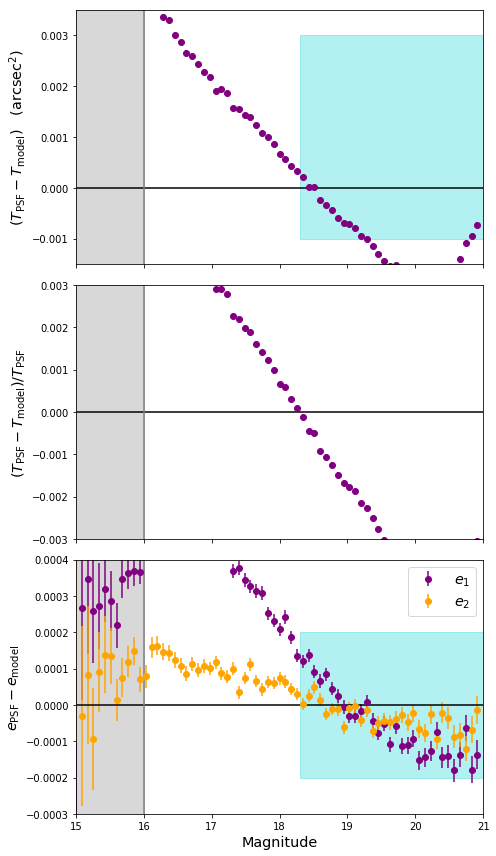

In [15]:
bin_by_mag(data['mag'], sizeres, fracsizeres, e1res, e2res, 16)

In [8]:
display('dpsf_mag.pdf')

'dpsf_mag.pdf'